# HANC with a Welfare State

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test 1: Solving and simulating the household problem](#toc2_)    
- 3. [Test 2: Evaluating the objective for finding the steady state](#toc3_)    
- 4. [Find stationary equilibrium](#toc4_)    
- 5. [Grid search](#toc5_)    
- 6. [Policy functions](#toc6_)    
- 7. [Simulation](#toc7_)    
- 8. [Test transition path](#toc8_)    
- 9. [Find transition path](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [87]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [88]:
model = HANCWelfareModelClass(name='baseline')

In [89]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [90]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)
ss.chi = 0.0
ss.S = 0.0
ss.tau = 0.015

We can now solve and simulate:

In [91]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.6 secs [345 iterations]


In [92]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 0.0 secs [402 iterations]


And we can check whether the results make sort of sense:

In [93]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

model.ss.A_hh = 2.01
model.ss.L_hh = 1.07
model.ss.C_hh = 0.77


note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.9 secs
household problem simulated along transition in 1.0 secs



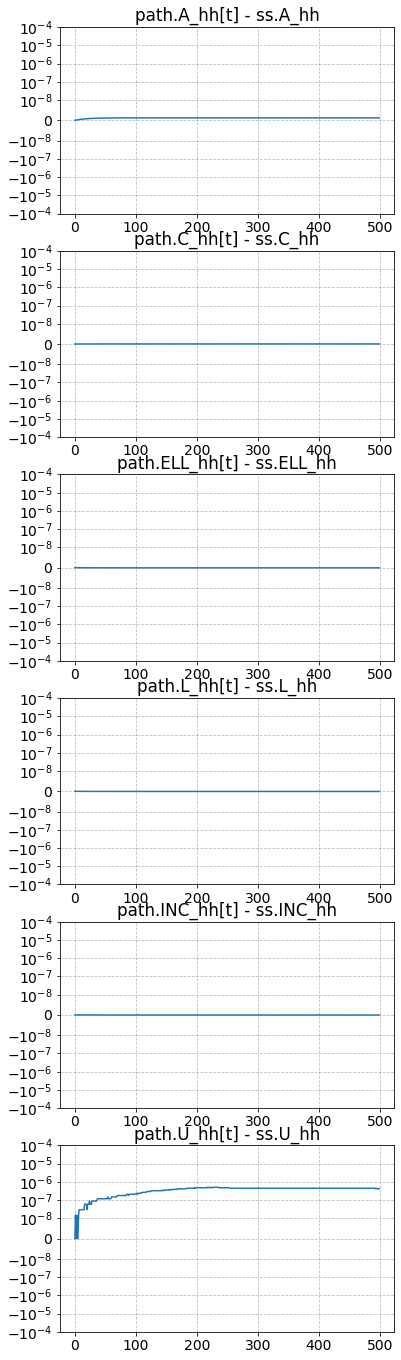

In [94]:
model.test_hh_path()

## 3. <a id='toc3_'></a>[Test 2: Evaluating the objective for finding the steady state](#toc0_)

We can try out various inputs and look at the outputs:

In [96]:
# model.ss.G = 0.0
# model.ss.LG = 0.0
tau = 0.1
for KL in [2.0,3.0,4.0]:
    clearing_A = obj_ss(np.array([KL,tau]),model,do_print=False)
    print(f'{KL = :.2f} -> {clearing_A = :12.8f}')

/home/b163467@PROD.SITAD.DK/AdvMacroHet/Assignments/Assignment_II/steady_state.py:101: RuntimeWarning: invalid value encountered in double_scalars
  ss.Y = par.Gamma_Y*ss.K**(par.alpha)*ss.LY**(1-par.alpha)


KL = 2.00 -> clearing_A = -102.22496322


ValueError: solve_hh_ss(), too many iterations

## 4. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

In [99]:
model.find_ss(LG=0.1,do_print=True)

starting at KL=3.8624


KeyboardInterrupt: 

In [86]:
def target(tau):
    
    model.find_ss(tau)
    return -ss.U_hh

res = optimize.minimize_scalar(target,bounds=(0.1,0.15),method='bounded',
                            options={'disp':3,'maxiter':5})
tau_max_U_hh = res.x
max_U_hh = res.fun

ValueError: solve_hh_ss(), too many iterations

In [ ]:
V_hh_ss = np.sum([par.beta**t*ss.U_hh for t in range(par.T)])
print(f'{V_hh_ss:.4f}')

In [73]:
model.info(only_blocks=True)

production_firm: [K] -> [LY,rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
government: [tau,w,chi] -> [B,wt,G,LG,S]
hh: [S,chi,r,tau,wt] -> [A_hh,C_hh,ELL_hh,L_hh,INC_hh,U_hh]
market_clearing: [A,A_hh,L,LY,LG,L_hh,Y,C_hh,K,G] -> [I,clearing_A,clearing_L,clearing_Y]


In [62]:
print(f"wage (ss.w) = {model.ss.w:.2f}")
print(f"tax rate (ss.tau) = {model.ss.tau}")
print(f"after-tax wage (ss.wt) = {model.ss.wt}")
print(f"government labor (ss.LG) = {model.ss.LG}")
print(f"government services (ss.S) = {model.ss.S}")
print(f"government spendings (ss.G) = {model.ss.G}")
print(f"firm labor (ss.LY) = {model.ss.LY}")
print(f"household labor (ss.L_hh) = {model.ss.L_hh}")
print(f"labor (ss.L) = {model.ss.L}")
print(f"Assets (ss.A) = {model.ss.A}")
print(f"Rented Capital (ss.rk) = {model.ss.rK}")
print(f"Capital (ss.K) = {model.ss.K}")

wage (ss.w) = 1.06
tax rate (ss.tau) = 0.015
after-tax wage (ss.wt) = 1.0450865726089194
government labor (ss.LG) = 0.020693259532516006
government services (ss.S) = -0.014169095946803332
government spendings (ss.G) = -0.014169095946803332
firm labor (ss.LY) = 0.9242985632095473
household labor (ss.L_hh) = 0.9449918227420633
labor (ss.L) = 0.9449918227420633
Assets (ss.A) = 3.697194252838189
Rented Capital (ss.rk) = 0.11367874248827986
Capital (ss.K) = 3.697194252838189


## 5. <a id='toc5_'></a>[Grid search](#toc0_)

In [213]:
par.tau_ss = 0.0
KL_min = ((1/par.beta+par.delta-1)/(par.alpha*par.Gamma_Y))**(1/(par.alpha-1))
KL_max = (par.delta/(par.alpha*par.Gamma_Y))**(1/(par.alpha-1))

In [215]:
NKL = 10
KL_vec = np.hstack((np.linspace(KL_min+1e-2,KL_max-1e-2,NKL),np.linspace(KL_max+1e-2,10.0,NKL)))
clearing_A_vec = np.nan*np.ones(KL_vec.size)
r_vec = np.nan*np.ones(KL_vec.size)

model_ = model.copy()
for i,KL in enumerate(KL_vec):
    print(f'{KL = :6.2f}: ',end='')
    try:
        clearing_A_vec[i] = obj_ss(np.array([KL,0.2]),model_,do_print=False)
        r_vec[i] = model_.ss.r
        print(f'clearing_A = {clearing_A_vec[i]:16.8f}')
    except Exception as e:
        print(e)

KL =   2.93: 

/home/b163467@PROD.SITAD.DK/AdvMacroHet/Assignments/Assignment_II/steady_state.py:82: RuntimeWarning: invalid value encountered in double_scalars
  ss.Y = par.Gamma_Y*ss.K**(par.alpha)*ss.LY**(1-par.alpha)


setting an array element with a sequence.
KL =   3.14: setting an array element with a sequence.
KL =   3.34: setting an array element with a sequence.
KL =   3.55: setting an array element with a sequence.
KL =   3.76: setting an array element with a sequence.
KL =   3.97: setting an array element with a sequence.
KL =   4.17: setting an array element with a sequence.
KL =   4.38: setting an array element with a sequence.
KL =   4.59: setting an array element with a sequence.
KL =   4.79: setting an array element with a sequence.
KL =   4.81: setting an array element with a sequence.
KL =   5.39: setting an array element with a sequence.
KL =   5.97: setting an array element with a sequence.
KL =   6.54: setting an array element with a sequence.
KL =   7.12: setting an array element with a sequence.
KL =   7.70: setting an array element with a sequence.
KL =   8.27: setting an array element with a sequence.
KL =   8.85: setting an array element with a sequence.
KL =   9.42: setting an

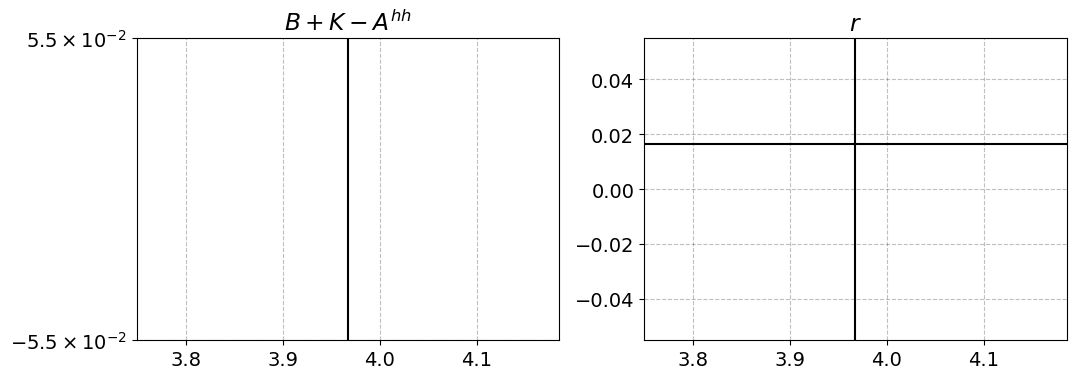

In [216]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('$B+K-A^{hh}$')
ax.plot(KL_vec[:NKL],clearing_A_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],clearing_A_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black')
ax.set_yscale('symlog')

ax = fig.add_subplot(1,2,2)
ax.set_title('$r$')
ax.plot(KL_vec[:NKL],r_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],r_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black');
ax.axhline(ss.r,color='black');

## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

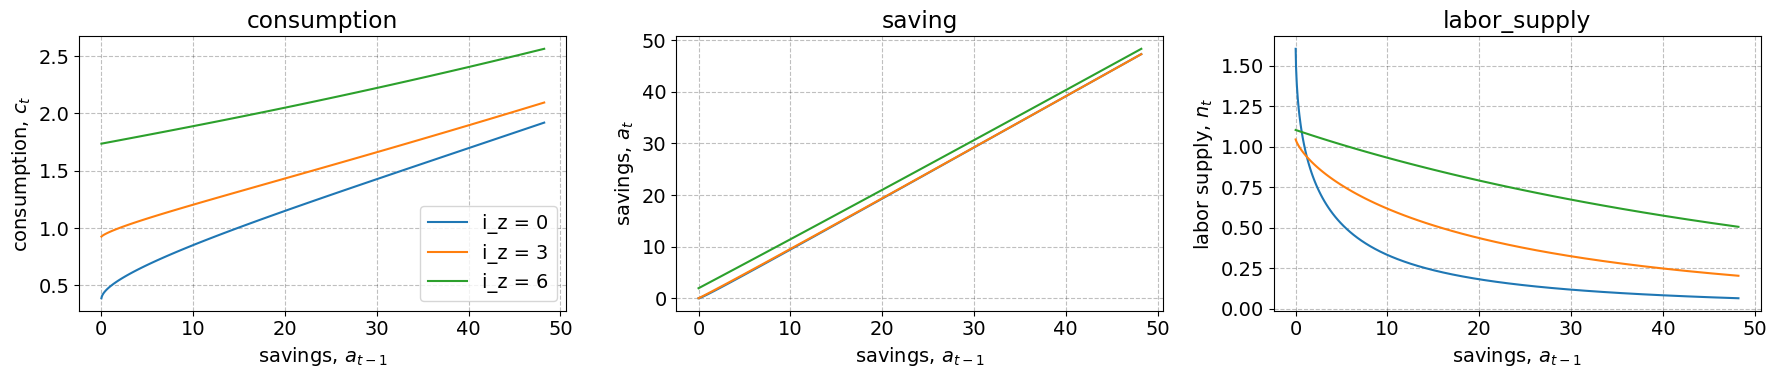

In [14]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()
plt.show()

## 7. <a id='toc7_'></a>[Simulation](#toc0_)

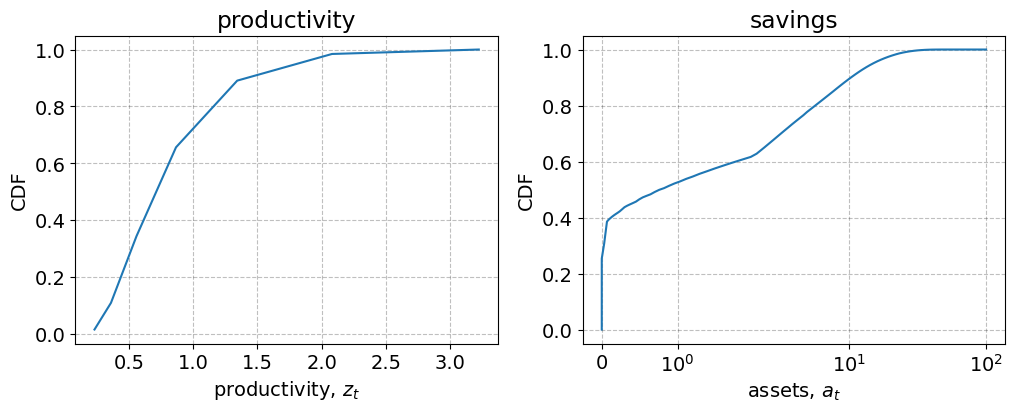

In [15]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D,axis=(0,2)))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

## 8. <a id='toc8_'></a>[Test transition path](#toc0_)

In [60]:
try:
    model.test_ss()
except Exception as e:
    print('you need to update GEModelTools to call this function (optional)')

you need to update GEModelTools to call this function (optional)


note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.9 secs
household problem simulated along transition in 0.1 secs



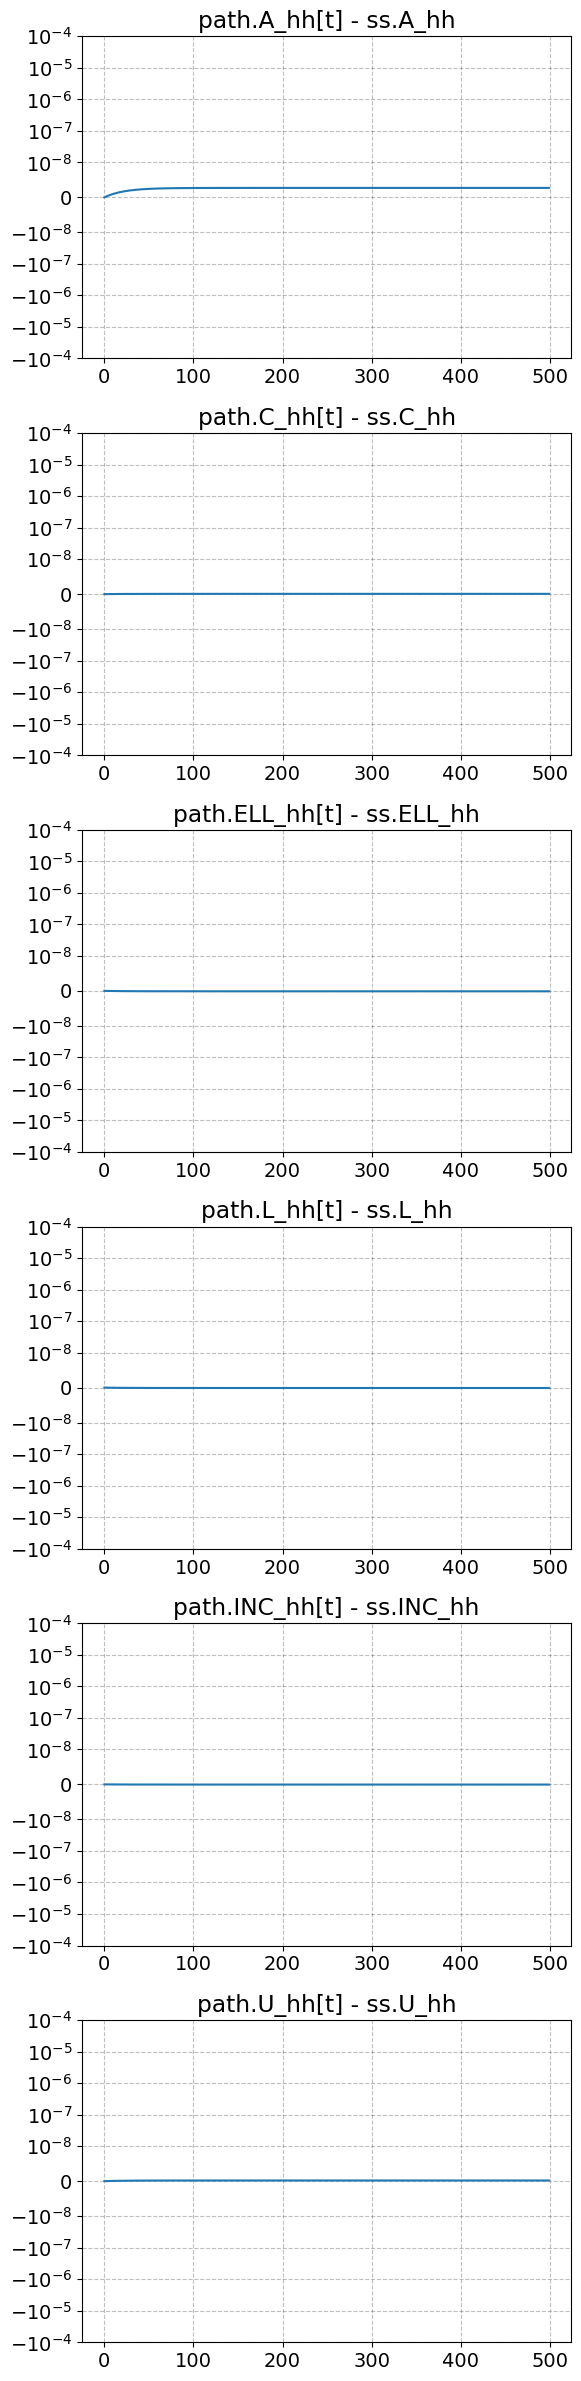

In [17]:
model.test_hh_path()

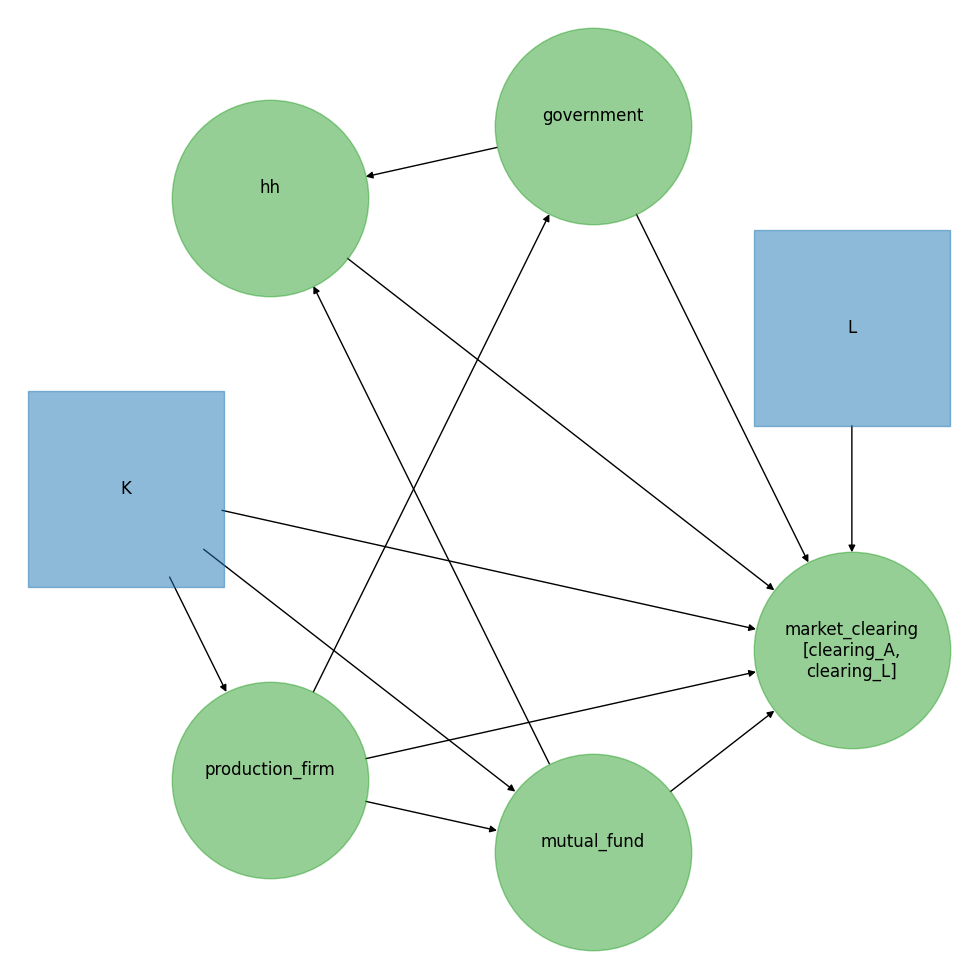

In [61]:
model.draw_DAG()

In [62]:
model.test_path(in_place=True)

shocks: 
unknowns: K L 

blocks.production_firm
 LY                   nan
 rK                   nan
 w                    nan
 Y                    nan
blocks.mutual_fund
 A                    nan
 r                    nan
blocks.government
 B                    nan
 tau                  nan
 wt                   nan
 G                    nan
hh


AssertionError: invalid values in path.r

## 9. <a id='toc9_'></a>[Find transition path](#toc0_)

In [20]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 1.2 secs
curly_Y and curly_D calculated for wt              in 1.3 secs
curly_E calculated in 2.2 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 4.9 secs

full Jacobians:
full Jacobian to unknowns computed in 0.7 secs [in evaluate_blocks(): 0.3 secs]
full Jacobian to shocks computed in 0.1 secs [in evaluate_blocks(): 0.0 secs]


In [21]:
model.find_transition_path(shocks=[],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 2.70e-09
   2.70e-09 in clearing_A
   1.04e-10 in clearing_L
 it =   1 -> max. abs. error = 1.39e-13
   1.39e-13 in clearing_A
   3.44e-15 in clearing_L

transition path found in 3.3 secs
